In [1]:
import re

In [10]:
#Parcel class defines a parcel record based on the attribute schema
class Parcel:
	#Class vars go here

	#Initialize a parcel object
	def __init__(self,row,fieldNames):
		# self.objectid = row[fieldNames.index("OID@")]
		# self.shape = row[fieldNames.index("SHAPE@")]
		self.stateid = row[fieldNames.index("STATEID")]
		self.parcelid = row[fieldNames.index("PARCELID")]
		self.taxparcelid = row[fieldNames.index("TAXPARCELID")]
		self.parceldate = row[fieldNames.index("PARCELDATE")]
		self.taxrollyear = row[fieldNames.index("TAXROLLYEAR")]
		self.ownernme1 = row[fieldNames.index("OWNERNME1")]
		self.ownernme2 = row[fieldNames.index("OWNERNME2")]
		self.pstladress = row[fieldNames.index("PSTLADRESS")]
		self.siteadress = row[fieldNames.index("SITEADRESS")]
		self.addnumprefix = row[fieldNames.index("ADDNUMPREFIX")]
		self.addnum = row[fieldNames.index("ADDNUM")]
		self.addnumsuffix = row[fieldNames.index("ADDNUMSUFFIX")]
		self.prefix = row[fieldNames.index("PREFIX")]
		self.streetname = row[fieldNames.index("STREETNAME")]
		self.streettype = row[fieldNames.index("STREETTYPE")]
		self.suffix = row[fieldNames.index("SUFFIX")]
		self.landmarkname = row[fieldNames.index("LANDMARKNAME")]
		self.unittype = row[fieldNames.index("UNITTYPE")]
		self.unitid = row[fieldNames.index("UNITID")]
		self.placename = row[fieldNames.index("PLACENAME")]
		self.zipcode = row[fieldNames.index("ZIPCODE")]
		self.zip4 = row[fieldNames.index("ZIP4")]
		self.state = row[fieldNames.index("STATE")]
		self.schooldist = row[fieldNames.index("SCHOOLDIST")]
		self.schooldistno = row[fieldNames.index("SCHOOLDISTNO")]
		self.cntassdvalue = row[fieldNames.index("CNTASSDVALUE")]
		self.lndvalue = row[fieldNames.index("LNDVALUE")]
		self.impvalue = row[fieldNames.index("IMPVALUE")]
		self.mflvalue = row[fieldNames.index("MFLVALUE")]
		self.estfmkvalue = row[fieldNames.index("ESTFMKVALUE")]
		self.netprpta = row[fieldNames.index("NETPRPTA")]
		self.grsprpta = row[fieldNames.index("GRSPRPTA")]
		self.propclass = row[fieldNames.index("PROPCLASS")]
		self.auxclass = row[fieldNames.index("AUXCLASS")]
		self.assdacres = row[fieldNames.index("ASSDACRES")]
		self.deedacres = row[fieldNames.index("DEEDACRES")]
		self.gisacres = row[fieldNames.index("GISACRES")]
		self.coname = row[fieldNames.index("CONAME")]
		self.loaddate = row[fieldNames.index("LOADDATE")]
		self.parcelfips = row[fieldNames.index("PARCELFIPS")]
		self.parcelsrc = row[fieldNames.index("PARCELSRC")]
		self.shapeLength = row[fieldNames.index("Shape_Length")]
		self.shapeArea = row[fieldNames.index("Shape_Area")]
		# self.shapeXY = row[fieldNames.index("SHAPE@XY")]
		self.geometricErrors = []
		self.addressErrors = []
		self.taxErrors = []
		self.generalErrors = []

	def writeErrors(self, row, cursor, fieldNames):
		#Write all accumulated errors to their respective rows, then update the row within the cursor
		if len(self.addressErrors) > 0:
			row[fieldNames.index("AddressElementErrors")] = str(self.addressErrors).strip('[]').replace("'","").replace('"','').replace(",","  | ").replace("#","'").replace(";",",")
		if len(self.generalErrors) > 0:
			row[fieldNames.index("GeneralElementErrors")] = str(self.generalErrors).strip('[]').replace("'","").replace('"','').replace(",","  | ").replace("#","'").replace(";",",")
		if len(self.taxErrors) > 0:
			row[fieldNames.index("TaxrollElementErrors")] = str(self.taxErrors).strip('[]').replace("'","").replace('"','').replace(",","  | ").replace("#","'").replace(";",",")
		if len(self.geometricErrors) > 0:
			row[fieldNames.index("GeometricElementErrors")] = str(self.geometricErrors).strip('[]').replace("'","").replace('"','').replace(",","  | ").replace("#","'").replace(";",",")
		cursor.updateRow(row)

In [11]:
import math

In [12]:
class Error:

	def __init__(self,featureClass,coName):
		self.coName = coName
		self.generalErrorCount = 0
		self.geometricErrorCount = 0
		self.addressErrorCount = 0
		self.taxErrorCount = 0
		self.comparisonDict = {}
		self.attributeFileErrors = []
		self.geometricFileErrors = []
		self.geometricPlacementErrors = []
		self.pinSkipCount = 0
		self.trYearPast = 0
		self.trYearExpected = 0
		self.trYearFuture = 0
		self.trYearOther = 0
		self.coNameMiss = 0
		self.fipsMiss = 0
		self.srcMiss = 0
		self.netMoreGrsCnt = 0
		self.recordIterationCount = 0
		datasource = ogr.GetDriverByName('OpenFileGDB').Open(featureClass, 0)
		self.recordTotalCount = datasource.GetLayerCount() # Total number of records in the feature class
		self.checkEnvelopeInterval = math.trunc(self.recordTotalCount / 100) # Interval value used to apply 10 total checks on records at evenly spaced intervals throughout the dataset.
		self.nextEnvelopeInterval = self.checkEnvelopeInterval
		self.notConfirmGeomCount = 0 #counts parcels with invalid Geometry
		self.validatedGeomCount = 0 #counts parcels whose geometry is validated
		self.geometryNotValidated = False
		self.geometryNotChecked = True
		self.mflLnd = 0
		self.diffxy = 0
		self.xyShift = 0
		self.codedDomainfields = []
		self.badcharsCount = 0
		self.uniqueparcelDatePercent = 0.0
		self.ErrorSum = 0   #sum of generalErrorCount, geometricErrorCount, addressErrorCount, taxErrorCount
		self.flags_dict = {'numericCheck': 0, 'duplicatedCheck': 0, 'prefixDom': 0, 'streettypeDom': 0, 'unittype': 0, 'placenameDom': 0, 'suffixDom': 0, 'trYear': 0, 'taxrollYr': 0, 'streetnameDom': 0, 'zipCheck': 0, 'cntCheck': 0, 'redundantId': 0, 'postalCheck':0, 'auxPropCheck': 0, 'fairmarketCheck': 0, 'mflvalueCheck': 0, 'auxclassFullyX4': 0, 'cntPropClassCheck': 0, 'matchContrib': 0, 'netvsGross': 0, 'schoolDist': 0 }

Change file directories for these for your local machine

In [13]:
test_counties = r'D:\Data Storage\Parcel\Test_counties.gdb'
second_test_counties = r'D:\Data Storage\Parcel\GUI\TEST_DATASET_PARCELS_2022\TEST_DATASET_PARCELS_2022.gdb'

In [14]:
base = r'D:\Data Storage\Parcel'

In [15]:
base

'D:\\Data Storage\\Parcel'

In [16]:
streetTypes = [line.strip() for line in open('D:\Data Storage\Parcel\GUI\data\V7_StreetType_Simplified.txt')] #street types domain list
unitIdTypes = [line.strip() for line in open('D:\Data Storage\Parcel\GUI\data\V7_UnitId_Simplified.txt')] #unitid domain list
unitTypes = [line.strip() for line in open('D:\Data Storage\Parcel\GUI\data\V7_UnitType_Simplified.txt')] #unit type domain list
lsadDomains = [line.strip() for line in open('D:\Data Storage\Parcel\GUI\data\LSAD_Simplified.txt')] #lsad domain list
taxRollYears = [line.strip() for line in open('D:\Data Storage\Parcel\GUI\data\V7_TaxRollYears.txt')] #taxroll years to test (past,expected,future1,future2)
suffixDomains = [line.strip() for line in open('D:\Data Storage\Parcel\GUI\data\V7_SuffixDomains_Simplified.txt')] #suffix domain list
prefixDomains = [line.strip() for line in open('D:\Data Storage\Parcel\GUI\data\V7_PrefixDomains_Simplified.txt')] #prefix domain list
pinSkips = [line.strip() for line in open('D:\Data Storage\Parcel\GUI\data\V7_PinSkips.txt')] #list of non-parcelid values found in field to ignore when checking for dups (and use in other functions)

# Geopandas

In [17]:
import geopandas as gpd

In [18]:
counties = gpd.read_file(test_counties, layer = 'TREMPEALEAU')

In [19]:
counties

,STATEID,PARCELID,TAXPARCELID,PARCELDATE,TAXROLLYEAR,OWNERNME1,OWNERNME2,PSTLADRESS,SITEADRESS,ADDNUMPREFIX,...,LOADDATE,PARCELFIPS,PARCELSRC,GeneralElementErrors,AddressElementErrors,TaxrollElementErrors,GeometricElementErrors,Shape_Length,Shape_Area,geometry
0,None,002-00821-0000,002008210000,05/05/2017,2021,HIGHTOWER RIDGE LLC,None,W25498 SULLIVAN RD TREMPEALEAU WI 54661,W23825 COUNTY RD H,None,...,None,121,TREMPEALEAU,None,None,None,None,1607.887849,161581.138144,"MULTIPOLYGON (((408090.749 449812.515, 408081...."
1,None,002-00817-0000,002008170000,05/05/2017,2021,LYNN NELSON,None,W24354 COUNTY RD H ELEVA WI 54738,W24354 COUNTY RD H,None,...,None,121,TREMPEALEAU,None,None,None,None,1603.079715,160614.848054,"MULTIPOLYGON (((407286.559 449828.123, 407278...."
2,None,002-00816-0000,002008160000,05/05/2017,2021,LYNN NELSON,None,W24354 COUNTY RD H ELEVA WI 54738,None,None,...,None,121,TREMPEALEAU,None,None,None,None,1602.912634,160574.319951,"MULTIPOLYGON (((406883.730 449834.970, 406878...."
3,None,002-00773-0000,002-00773-0000,05/05/2017,2021,BRIAN E JOHNSON,SUSAN M JOHNSON,683 ZEPHYR LN HUDSON WI 54016,None,None,...,None,121,TREMPEALEAU,None,None,None,None,1596.195193,159234.848510,"MULTIPOLYGON (((404476.952 449487.060, 404076...."
4,None,002-00774-0000,002007740000,05/05/2017,2021,BRIAN E JOHNSON,SUSAN M JOHNSON,683 ZEPHYR LN HUDSON WI 54016,None,None,...,None,121,TREMPEALEAU,None,None,None,None,1596.445895,159288.134489,"MULTIPOLYGON (((404877.442 449480.286, 404476...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32922,None,None,None,None,2021,None,None,None,None,None,...,None,121,TREMPEALEAU,None,None,None,None,227.561979,1964.178250,"MULTIPOLYGON (((414499.987 433784.245, 414411...."
32923,None,231-00730-0005,231007300005,None,2021,RIDGEVIEW ESTATES LLC,None,5144 CEDAR HAMMOCK LN SARASOTA FL 34232,None,None,...,None,121,TREMPEALEAU,None,None,None,None,131.190226,808.042163,"MULTIPOLYGON (((408984.791 401297.833, 408984...."
32924,None,016-01346-0016,016013460016,None,2021,NICHOLAS STONER,BEATRICE STONER,N19770 US HWY 53 GALESVILLE WI 54630,None,None,...,None,121,TREMPEALEAU,None,None,None,None,228.262555,3244.677065,"MULTIPOLYGON (((408962.673 401339.607, 408908...."
32925,None,028-00114-0000,028001140000,None,2021,RICK T & BETH A WELTZIEN REVOCABLE TRUST,None,N20222 STATE RD 93 GALESVILLE WI 54630,None,None,...,None,121,TREMPEALEAU,None,None,None,None,1370.287997,113764.776026,"MULTIPOLYGON (((405340.077 407023.878, 405059...."


<AxesSubplot: >

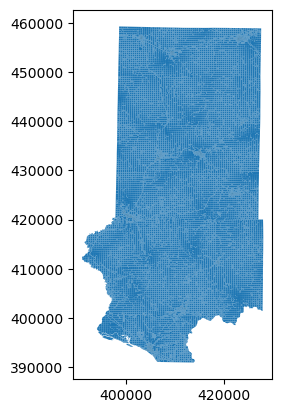

In [12]:
counties.plot()

In [20]:
working_counties = counties.copy(deep = True)

In [21]:
working_counties

,STATEID,PARCELID,TAXPARCELID,PARCELDATE,TAXROLLYEAR,OWNERNME1,OWNERNME2,PSTLADRESS,SITEADRESS,ADDNUMPREFIX,...,LOADDATE,PARCELFIPS,PARCELSRC,GeneralElementErrors,AddressElementErrors,TaxrollElementErrors,GeometricElementErrors,Shape_Length,Shape_Area,geometry
0,None,002-00821-0000,002008210000,05/05/2017,2021,HIGHTOWER RIDGE LLC,None,W25498 SULLIVAN RD TREMPEALEAU WI 54661,W23825 COUNTY RD H,None,...,None,121,TREMPEALEAU,None,None,None,None,1607.887849,161581.138144,"MULTIPOLYGON (((408090.749 449812.515, 408081...."
1,None,002-00817-0000,002008170000,05/05/2017,2021,LYNN NELSON,None,W24354 COUNTY RD H ELEVA WI 54738,W24354 COUNTY RD H,None,...,None,121,TREMPEALEAU,None,None,None,None,1603.079715,160614.848054,"MULTIPOLYGON (((407286.559 449828.123, 407278...."
2,None,002-00816-0000,002008160000,05/05/2017,2021,LYNN NELSON,None,W24354 COUNTY RD H ELEVA WI 54738,None,None,...,None,121,TREMPEALEAU,None,None,None,None,1602.912634,160574.319951,"MULTIPOLYGON (((406883.730 449834.970, 406878...."
3,None,002-00773-0000,002-00773-0000,05/05/2017,2021,BRIAN E JOHNSON,SUSAN M JOHNSON,683 ZEPHYR LN HUDSON WI 54016,None,None,...,None,121,TREMPEALEAU,None,None,None,None,1596.195193,159234.848510,"MULTIPOLYGON (((404476.952 449487.060, 404076...."
4,None,002-00774-0000,002007740000,05/05/2017,2021,BRIAN E JOHNSON,SUSAN M JOHNSON,683 ZEPHYR LN HUDSON WI 54016,None,None,...,None,121,TREMPEALEAU,None,None,None,None,1596.445895,159288.134489,"MULTIPOLYGON (((404877.442 449480.286, 404476...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32922,None,None,None,None,2021,None,None,None,None,None,...,None,121,TREMPEALEAU,None,None,None,None,227.561979,1964.178250,"MULTIPOLYGON (((414499.987 433784.245, 414411...."
32923,None,231-00730-0005,231007300005,None,2021,RIDGEVIEW ESTATES LLC,None,5144 CEDAR HAMMOCK LN SARASOTA FL 34232,None,None,...,None,121,TREMPEALEAU,None,None,None,None,131.190226,808.042163,"MULTIPOLYGON (((408984.791 401297.833, 408984...."
32924,None,016-01346-0016,016013460016,None,2021,NICHOLAS STONER,BEATRICE STONER,N19770 US HWY 53 GALESVILLE WI 54630,None,None,...,None,121,TREMPEALEAU,None,None,None,None,228.262555,3244.677065,"MULTIPOLYGON (((408962.673 401339.607, 408908...."
32925,None,028-00114-0000,028001140000,None,2021,RICK T & BETH A WELTZIEN REVOCABLE TRUST,None,N20222 STATE RD 93 GALESVILLE WI 54630,None,None,...,None,121,TREMPEALEAU,None,None,None,None,1370.287997,113764.776026,"MULTIPOLYGON (((405340.077 407023.878, 405059...."


In [15]:
working_counties = working_counties.assign(GeneralElementErrors = str(), 
                                           AddressElementErrors = str(), 
                                           TaxrollElementErrors = str(), 
                                           GeometricElementErrors = str())

# working_counties = working_counties.fillna("")

In [16]:
working_counties.columns

Index(['STATEID', 'PARCELID', 'TAXPARCELID', 'PARCELDATE', 'TAXROLLYEAR',
       'OWNERNME1', 'OWNERNME2', 'PSTLADRESS', 'SITEADRESS', 'ADDNUMPREFIX',
       'ADDNUM', 'ADDNUMSUFFIX', 'PREFIX', 'STREETNAME', 'STREETTYPE',
       'SUFFIX', 'LANDMARKNAME', 'UNITTYPE', 'UNITID', 'PLACENAME', 'ZIPCODE',
       'ZIP4', 'STATE', 'SCHOOLDIST', 'SCHOOLDISTNO', 'CNTASSDVALUE',
       'LNDVALUE', 'IMPVALUE', 'MFLVALUE', 'ESTFMKVALUE', 'NETPRPTA',
       'GRSPRPTA', 'PROPCLASS', 'AUXCLASS', 'ASSDACRES', 'DEEDACRES',
       'GISACRES', 'CONAME', 'LOADDATE', 'PARCELFIPS', 'PARCELSRC',
       'GeneralElementErrors', 'AddressElementErrors', 'TaxrollElementErrors',
       'GeometricElementErrors', 'Shape_Length', 'Shape_Area', 'geometry'],
      dtype='object')

In [17]:
working_counties

,STATEID,PARCELID,TAXPARCELID,PARCELDATE,TAXROLLYEAR,OWNERNME1,OWNERNME2,PSTLADRESS,SITEADRESS,ADDNUMPREFIX,...,LOADDATE,PARCELFIPS,PARCELSRC,GeneralElementErrors,AddressElementErrors,TaxrollElementErrors,GeometricElementErrors,Shape_Length,Shape_Area,geometry
0,None,002-00821-0000,002008210000,05/05/2017,2021,HIGHTOWER RIDGE LLC,None,W25498 SULLIVAN RD TREMPEALEAU WI 54661,W23825 COUNTY RD H,None,...,None,121,TREMPEALEAU,,,,,1607.887849,161581.138144,"MULTIPOLYGON (((408090.749 449812.515, 408081...."
1,None,002-00817-0000,002008170000,05/05/2017,2021,LYNN NELSON,None,W24354 COUNTY RD H ELEVA WI 54738,W24354 COUNTY RD H,None,...,None,121,TREMPEALEAU,,,,,1603.079715,160614.848054,"MULTIPOLYGON (((407286.559 449828.123, 407278...."
2,None,002-00816-0000,002008160000,05/05/2017,2021,LYNN NELSON,None,W24354 COUNTY RD H ELEVA WI 54738,None,None,...,None,121,TREMPEALEAU,,,,,1602.912634,160574.319951,"MULTIPOLYGON (((406883.730 449834.970, 406878...."
3,None,002-00773-0000,002-00773-0000,05/05/2017,2021,BRIAN E JOHNSON,SUSAN M JOHNSON,683 ZEPHYR LN HUDSON WI 54016,None,None,...,None,121,TREMPEALEAU,,,,,1596.195193,159234.848510,"MULTIPOLYGON (((404476.952 449487.060, 404076...."
4,None,002-00774-0000,002007740000,05/05/2017,2021,BRIAN E JOHNSON,SUSAN M JOHNSON,683 ZEPHYR LN HUDSON WI 54016,None,None,...,None,121,TREMPEALEAU,,,,,1596.445895,159288.134489,"MULTIPOLYGON (((404877.442 449480.286, 404476...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32922,None,None,None,None,2021,None,None,None,None,None,...,None,121,TREMPEALEAU,,,,,227.561979,1964.178250,"MULTIPOLYGON (((414499.987 433784.245, 414411...."
32923,None,231-00730-0005,231007300005,None,2021,RIDGEVIEW ESTATES LLC,None,5144 CEDAR HAMMOCK LN SARASOTA FL 34232,None,None,...,None,121,TREMPEALEAU,,,,,131.190226,808.042163,"MULTIPOLYGON (((408984.791 401297.833, 408984...."
32924,None,016-01346-0016,016013460016,None,2021,NICHOLAS STONER,BEATRICE STONER,N19770 US HWY 53 GALESVILLE WI 54630,None,None,...,None,121,TREMPEALEAU,,,,,228.262555,3244.677065,"MULTIPOLYGON (((408962.673 401339.607, 408908...."
32925,None,028-00114-0000,028001140000,None,2021,RICK T & BETH A WELTZIEN REVOCABLE TRUST,None,N20222 STATE RD 93 GALESVILLE WI 54630,None,None,...,None,121,TREMPEALEAU,,,,,1370.287997,113764.776026,"MULTIPOLYGON (((405340.077 407023.878, 405059...."


In [18]:
#Check if text value is a valid number(Error object, Parcel object, field to test, type of error to classify this as, are <Null>s are considered errors?)
def checkNumericTextValue(Error,Parcel,field,errorType,acceptNull):
    nullList = [None, "<Null>", "<NULL>", "NULL", " ", ""]
    try:
        stringToTest = getattr(Parcel,field)
        if stringToTest:
            try:
                int(stringToTest)  # or float(stringToTest):
            except ValueError:
                try:
                    float(stringToTest)
                except ValueError:
                    try:
                        if stringToTest in nullList or stringToTest.isspace():
                            getattr(Parcel,errorType + "Errors").append("String values of #<Null>#; #NULL# or blanks occurred in " + field.upper() + ". Please correct.")
                            setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
                            Error.badcharsCount  += 1
                            return (Error, Parcel)  #for wrong <null> values
                        else:
                            getattr(Parcel,errorType + "Errors").append("Value in " + field.upper() + " does not appear to be a numeric value.")
                            setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
                            Error.flags_dict['numericCheck'] += 1
                            return (Error, Parcel)
                    except: pass
        else:
            if acceptNull:
                pass
            else:
                getattr(Parcel,errorType + "Errors").append("<Null> Found on " + field.upper())
                setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
                if field == 'parcelfips' :
                    Error.flags_dict['matchContrib'] += 1

            return (Error, Parcel)
    except: # using generic error handling because we don't know what errors to expect yet.
        getattr(Parcel,errorType + "Errors").append("An unknown issue occurred with the " + field.upper() + "field. Please inspect the value of this field.")
        setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
    return (Error, Parcel)

In [19]:
	#Check to see if a domain string is within a list (good) otherwise report to user it isn't found..
	def checkDomainString(Error,Parcel,field,errorType,acceptNull,testList):
		nullList = ["<Null>", "<NULL>", "NULL",  "   ", " ", ""]
		try:
			stringToTest = getattr(Parcel,field)
			if field == 'placename':
				if stringToTest is not None:
					if  stringToTest in nullList or stringToTest.isspace() or any(x.islower() for x in stringToTest):
						getattr(Parcel,errorType + "Errors").append("String values of #<Null>#; #NULL# or blanks occurred in " + field.upper() + ". Please correct.")
						setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
						Error.badcharsCount  +=1   #for wrong <null> values
					elif any(substring in stringToTest for substring in testList):
						pass
					else:
						getattr(Parcel,errorType + "Errors").append("Value provided in " + field.upper() + " does not contain required LSAD descriptor.")
						setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
						Error.flags_dict['placenameDom'] += 1
					return (Error,Parcel)

			elif field == 'unitid' or field == 'unittype':
				if (stringToTest is None) or (stringToTest in testList) :
					#arcpy.AddMessage("This value is <Null>... or exists in our list...")
					pass
				else:
					getattr(Parcel,errorType + "Errors").append("The value in " + field.upper() + " is not in standardized domain list. Please standarize/spell out values for affected records.")
					setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
					Error.flags_dict['unitidtype'] += 1

				return (Error,Parcel)
			else:
				if stringToTest is not None:
					if  stringToTest in nullList or stringToTest.isspace() or any(x.islower() for x in stringToTest):
						getattr(Parcel,errorType + "Errors").append("String values of #<Null>#; #NULL# or blanks occurred in " + field.upper() + ". Please correct.")
						setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
						Error.badcharsCount  +=1   #for wrong <null> values

					elif stringToTest in testList:
						pass
					else:
						getattr(Parcel,errorType + "Errors").append("Value provided in " + field.upper() + " not in acceptable domain list.")
						setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
						Error_string = field + 'Dom'
						Error.flags_dict[Error_string] += 1

					return (Error, Parcel)
				else:
					if acceptNull:
						pass
					else:
						getattr(Parcel,errorType + "Errors").append("<Null> Found on " + field.upper())
						setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
					return (Error, Parcel)
		except: # using generic error handling because we don't know what errors to expect yet.
			getattr(Parcel,errorType + "Errors").append("An unknown issue occurred with the " + field.upper() + " field. Please inspect the value of this field.")
			setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
		return (Error, Parcel)

In [20]:
	#verify that the values provided in the zip field are 5 digits in length and begin with a '5'.
	def zipCheck(Error,Parcel,field,errorType,acceptNull):
		try:
			stringToTest = getattr(Parcel,field)
			if stringToTest is not None:
				if len(stringToTest) == 5 and stringToTest[0] == '5':
					pass
				else:
					getattr(Parcel,errorType + "Errors").append("Value provided in " + field.upper() + " is either not 5 digits long or does not appear to be a Wisconsin zipcode.")
					setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
					Error.flags_dict['zipCheck'] += 1
				return(Error,Parcel)

			else:
				if acceptNull:
					pass
				else:
					getattr(Parcel,errorType + "Errors").append("<Null> Found on " + field.upper() + " field and value is expected.")
					setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
					Error.flags_dict['zipCheck'] += 1
				return (Error, Parcel)

		except: # using generic error handling because we don't know what errors to expect yet.
			getattr(Parcel,errorType + "Errors").append("An unknown issue occurred with the " + field.upper() + " field. Please inspect the value of this field.")
			setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
		return (Error, Parcel)

	#verify that the values provided in the zip4 field is 4 characters long
	def zip4Check(Error,Parcel,field,errorType,acceptNull):
		try:
			stringToTest = getattr(Parcel, field)
			if stringToTest is not None:
				if len(stringToTest) == 4:
					pass
				else:
					getattr(Parcel,errorType + "Errors").append("Value provided in " + field.upper() + " is not 4 digits long.")
					setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
					Error.flags_dict['zipCheck'] += 1

				return (Error, Parcel)
			elif acceptNull:
				pass
		except:
			getattr(Parcel,errorType + "Errors").append("An unknown issue occurred with the " + field.upper() + " field. Please inspect the value of this field.")
			setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
		return(Error, Parcel)

In [21]:
	#Check to see if taxroll year provided is what expected, old, future or other value (which we plan to ask for explaination in submission form...)
	def trYear(Error,Parcel,field,pinField,errorType,acceptNull,ignoreList,acceptYears):
		nullList = [None, "<Null>", "<NULL>", "NULL", ""]
		try:
			stringToTest = getattr(Parcel,field)
			pinToTest = getattr(Parcel,pinField)
			if stringToTest is not None:
				if  stringToTest in nullList or stringToTest.isspace():
					getattr(Parcel,errorType + "Errors").append("String values of #<Null>#; #NULL# or blanks occurred in " + field.upper() + ". Please correct.")
					setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
					Error.badcharsCount  +=1   #for wrong <null> values
				elif stringToTest == acceptYears[0]:
					Error.trYearPast += 1
				elif stringToTest == acceptYears[1]:
					Error.trYearExpected += 1
				elif stringToTest == acceptYears[2] or stringToTest == acceptYears[3]:
					Error.trYearFuture += 1
				else:
					Error.trYearOther += 1
				return (Error, Parcel)
			else:
				if acceptNull:
					pass
				else:
					if pinToTest in ignoreList or pinToTest is None:
						Error.pinSkipCount += 1
					else:
						getattr(Parcel,errorType + "Errors").append("Value in " + field.upper() + " is flagged. See schema definition. In most cases; value should be expected year (" + acceptYears[1] + "); or future year (" + acceptYears[2] + ") if new parcel/split.")
						setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
						Error.flags_dict['trYear'] += 1

			return (Error, Parcel)
		except: # using generic error handling because we don't know what errors to expect yet.
			getattr(Parcel,errorType + "Errors").append("An unknown issue occurred with the " + field.upper() + " field. Please inspect the value of this field.")
			setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
		return (Error, Parcel)

	#Verify that all tax roll data is <Null> when the record represent a New Parcel (indicated by a future tax roll year)
	def taxrollYrCheck(Error,Parcel,field,errorType,acceptNull,pinField,acceptYears):
		nullList = [None, "<Null>", "<NULL>", "NULL", ""]
		try:
			taxRollYear = getattr(Parcel,field)
			taxRollFields = {'IMPVALUE': getattr(Parcel, "impvalue"), 'CNTASSDVALUE': getattr(Parcel, "cntassdvalue"),
			'LNDVALUE': getattr(Parcel, "lndvalue"), 'MFLVALUE': getattr(Parcel, "mflvalue"), 'ESTFMKVALUE': getattr(Parcel, "estfmkvalue"),
			'NETPRPTA': getattr(Parcel, "netprpta"), 'GRSPRPTA': getattr(Parcel, "grsprpta"),'ASSDACRES': getattr(Parcel, "assdacres"),
			'PROPCLASS': getattr(Parcel, "propclass"), 'AUXCLASS': getattr(Parcel, "auxclass")}
			probFields = []
			if taxRollYear is not None:
				if taxRollYear == acceptYears[2] or taxRollYear == acceptYears[3]:
					for key, val in taxRollFields.iteritems():
						if val is not None:
							probFields.append(key)
					if len(probFields) > 0:
						getattr(Parcel,errorType + "Errors").append("Future Year (" + str(taxRollYear) + ") found and " + " / ".join(probFields) + " field(s) is/are not <Null>. A <Null> value is expected in all tax roll data for records annotated with future tax roll years. Please verify.")
						setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
						Error.flags_dict['taxrollYr'] += 1

				else:  #other years are okay
					pass
				return (Error, Parcel)
			elif acceptNull:  # it is null -> TAXROLLYEAR for parcel splits/new parcels may be <Null>
				pass
		except: # using generic error handling because we don't know what errors to expect yet.
			getattr(Parcel,errorType + "Errors").append("An unknown issue occurred with the " + field.upper() + " field. Please inspect the value of this field.")
			setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
		return (Error, Parcel)

In [57]:
#Verify that CNTASSDVALUE is different to LandValue when ImpValue is greater than zero
def totCheck (Error,Parcel,field,cntassValue,landValue,errorType):
    try:
        impvalue = getattr(Parcel, field)
        cntassvalue = getattr(Parcel, cntassValue)
        lndvalue =  getattr(Parcel, landValue)
        if impvalue is None and cntassvalue is None and lndvalue is None:
            pass
        elif  (impvalue  is None or float(impvalue) == 0):
            if (cntassvalue is not None and lndvalue is not None) and (float(cntassvalue) == float(lndvalue)):
                #arcpy.AddMessage(impvalue)
                pass
            elif (cntassvalue is not None and lndvalue is not None) and (float(cntassvalue) != float(lndvalue)):
                getattr(Parcel,errorType + "Errors").append("Value provided in " + field.upper() + " is zero or <Null>. 'CNTASSDVALUE' should be equal to 'LNDVALUE' for this record - please verify.")
                setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
                Error.flags_dict['cntCheck'] += 1

        elif (impvalue is not None and float(impvalue) > 0):
            if (cntassvalue is not None and lndvalue is not None) and (float(cntassvalue) > float(lndvalue)) :
                pass
            elif (cntassvalue is not None and lndvalue is not None) and (float(cntassvalue) == float(lndvalue)):
                getattr(Parcel,errorType + "Errors").append("Value provided in " + field.upper() + " is greater than zero. 'CNTASSDVALUE' should not be equal to 'LNDVALUE' for this record - please verify.")
                setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)  #Error.taxErrorCount +=
                Error.flags_dict['cntCheck'] += 1

        return(Error,Parcel)
    except:
        getattr(Parcel,errorType + "Errors").append("An unknown issue occurred with IMPROVED, LANDVALUE or CNTASSVALUE field. Please inspect the value of this field.")
        setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
    return(Error,Parcel)

    #checking ESTFMKVALUE field against PROPCLASS field for erroneous not null values when PROPCLASS of 4, 5, 5M or AUXCLASS field
# for erroneous not null values when AUXCLASS of x1-x4 or w1-w9 is present with another value
def fairMarketCheck(Error,Parcel,propClass,auxClass,estFmkValue,errorType):
    try:
        propClassTest = str(getattr(Parcel,propClass)).replace(" ","")
        auxClassValue = getattr(Parcel, auxClass)
        auxClassTest = str(getattr(Parcel,auxClass)).replace(" ","")
        estFmkValueTest = getattr(Parcel,estFmkValue)

        if estFmkValueTest is None and auxClassValue is None and propClassTest is not None:
            if  re.search('4', propClassTest) is None and re.search('5', propClassTest) is None and (re.search('1', propClassTest) is not None or re.search('2', propClassTest) is not None or re.search('3', propClassTest) is not None or re.search('6', propClassTest) is not None or re.search('7', propClassTest) is not None):
                getattr(Parcel, errorType + "Errors").append("A value greater than zero is expected in ESTFMKVALUE for fully taxable properties with PROPCLASS of (" + str(propClassTest) + "). Verify value.")
                setattr(Error, errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
                Error.flags_dict['fairmarketCheck'] += 1

            else:
                pass
        #elif estFmkValueTest is not None:
            #if re.search('4', propClassTest) is not None or re.search('5', propClassTest) is not None:
            #	getattr(Parcel, errorType + "Errors").append("A <Null> value is expected in ESTFMKVALUE for properties with PROPCLASS values of 4, 5 and 5M. Correct or verify.")
            #	setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)

            #if re.search('W', auxClassTest) is not None or re.search('X', auxClassTest) is not None:
            #	getattr(Parcel, errorType + "Errors").append("A <Null> value is expected in ESTFMKVALUE for properties with AUXCLASS of (" + str(auxClassTest) + "). Verify value.")
            #	setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
            #else:
            #	pass
            return(Error,Parcel)

    except:
        getattr(Parcel,errorType + "Errors").append("An unknown issue occurred with the " + propClass.upper() + "or" + estFmkValue.upper() + " field. Please inspect the values of these fields.")
        setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
    return (Error, Parcel)

    #check for valid postal address   ('CANULL' not in address or 'NULL BLVD' not in address ) or
def postalCheck (Error,Parcel,PostalAd,errorType,ignoreList,taxYear,pinField,badPstladdSet, acceptYears):
    nullList = ["<Null>", "<NULL>", "NULL", ""]
    try:
        address = getattr(Parcel,PostalAd)
        year = getattr(Parcel, taxYear)
        pinToTest = getattr(Parcel,pinField)
        if address is None:
            pass
        else:

            if address in nullList or address.isspace():

                getattr(Parcel,errorType + "Errors").append("String values of #<Null>#; #NULL# or blanks occurred in " + PostalAd.upper() + ". Please correct.")
                setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
                Error.flags_dict['postalCheck'] += 1
                Error.badcharsCount  += 1   #for wrong <null> values

            elif year is not None:
                if int(year) <= int(acceptYears[1]):   #or pinToTest in ignorelist:
                    if ('CANULL'  in address or 'NULL BLVD'  in address ):
                        pass

                    elif ('UNAVAILABLE' in address or 'ADDRESS' in address or 'ADDDRESS' in address or 'UNKNOWN' in address or ' 00000' in address or 'NULL' in address or  ('NONE' in address and 'HONONEGAH' not in address) or 'MAIL EXEMPT' in address or 'TAX EX' in address or 'UNASSIGNED' in address or 'N/A' in address) or(address in badPstladdSet) or any(x.islower() for x in address):
                        getattr(Parcel,errorType + "Errors").append("A value provided in the " + PostalAd.upper() + " field may contain an incomplete address. Please verify the value is correct or set to <Null> if complete address is unknown.")
                        setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
                        Error.flags_dict['postalCheck'] += 1

                    else:
                        pass
        return(Error,Parcel)
    except:
        getattr(Parcel,errorType + "Errors").append("An unknown issue occurred with the PSTLADRESS field.  Please inspect the value of this field.")
        setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
    return (Error, Parcel)

    #Check for PROP/AUX value existing when expected and then check existing values for dups and for values not in expected domain lists...(Makes classOfPropCheck fcn obsolete)
def auxPropCheck(Error,Parcel,propField,auxField,yearField,pinField,ignoreList,errorType,copDomainList,auxDomainList, acceptYears):
    nullList = ["<Null>", "<NULL>", "NULL", ""]
    try:
        year = getattr(Parcel,yearField)
        pinToTest = getattr(Parcel,pinField)
        copToTest = getattr(Parcel,propField)
        auxToTest = getattr(Parcel,auxField)
        testListCop = []
        testListAux = []
        if (pinToTest in ignoreList) or (pinToTest is None) or (year is not None and int(year) > int(acceptYears[1])):   #
            pass
        else:
            if copToTest is None and auxToTest is None:
                #arcpy.AddMessage( str(year) + " and " + str(acceptYears[1]) )
                getattr(Parcel,errorType + "Errors").append("The " + propField.upper() + " and " + auxField.upper() + " fields are <Null> and a value is expected for any non-new parcels.")
                setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
                Error.flags_dict['auxPropCheck'] += 1

            if copToTest is not None and (copToTest in nullList or copToTest.isspace()):
                    getattr(Parcel,errorType + "Errors").append("String values of #<Null>#; #NULL# or blanks occurred in " + propField.upper() + ". Please correct.")
                    setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
                    Error.badcharsCount  +=1   #for wrong <null> values

            elif copToTest is not None:
                checkVal = copToTest.split(",")
                for val in checkVal:
                    if val.strip() not in copDomainList:
                        getattr(Parcel,errorType + "Errors").append("A value provided in " + propField.upper() + " field is not in acceptable domain list.")
                        setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
                        Error.flags_dict['auxPropCheck'] += 1

                    elif val.strip() in testListCop:
                        getattr(Parcel,errorType + "Errors").append("Duplicate values exist in " + propField.upper() + " field.")
                        setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
                        Error.flags_dict['auxPropCheck'] += 1

                    else:
                        testListCop.append(val.strip())

            if auxToTest is not None and (auxToTest in nullList or auxToTest.isspace()):
                    getattr(Parcel,errorType + "Errors").append("String values of #<Null>#; #NULL# or blanks occurred in " + auxField.upper() + ". Please correct.")
                    setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
                    Error.badcharsCount  +=1   #for wrong <null> values

            elif auxToTest is not None:
                checkAuxVal = auxToTest.split(",")
                for val in checkAuxVal:
                    if val.strip() not in auxDomainList:
                        getattr(Parcel,errorType + "Errors").append("A value provided in " + auxField.upper() + " field is not in AUXCLASS domain list. Standardize values for AUXCLASS domains.")
                        setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
                        Error.flags_dict['auxPropCheck'] += 1

                    elif val.strip() in testListAux:
                        getattr(Parcel,errorType + "Errors").append("Duplicate values exist in " + auxField.upper() + " field.")
                        setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
                        Error.flags_dict['auxPropCheck'] += 1

                    else:
                        testListAux.append(val.strip())
        return(Error, Parcel)
    except:
        getattr(Parcel,errorType + "Errors").append("!!!!!!An unknown issue occurred with the " + propField.upper() + " and/or " + auxField.upper() + " field. Please inspect the values of these fields.")
        setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
    return (Error, Parcel)

def totalAssdValueCheck(Error,Parcel,cnt,lnd,imp,errorType):
    try:
        cnt = 0.0 if (getattr(Parcel,cnt) is None) else float(getattr(Parcel,cnt))
        lnd = 0.0 if (getattr(Parcel,lnd) is None) else float(getattr(Parcel,lnd))
        imp = 0.0 if (getattr(Parcel,imp) is None) else float(getattr(Parcel,imp))
        if lnd + imp != cnt:
            getattr(Parcel,errorType + "Errors").append("CNTASSDVALUE is not equal to LNDVALUE + IMPVALUE as expected.  Correct this issue and refer to the submission documentation for futher clarification as needed.")
            setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
            Error.flags_dict['cntCheck'] += 1
        return(Error,Parcel)
    except:
        getattr(Parcel,errorType + "Errors").append("An unknown issue occurred when comparing your CNTASSDVALUE value to the sum of LNDVALUE and IMPVALUE.  Please inspect these fields.")
        setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)

    return (Error, Parcel)

    # parcels with MFLValue should have auxclass of W1-W3 or W5-W9
def mfLValueCheck(Error, Parcel, mflvalue, auxField, errorType):
    try:
        mflValueTest = getattr(Parcel,mflvalue)
        auxToTest = getattr(Parcel,auxField)

        if mflValueTest is None or float(mflValueTest) == 0.0:
            if auxToTest is not None and re.search('W', auxToTest) is not None and re.search('AW', auxToTest) is  None and re.search('W4', auxToTest) is  None and re.search('W10', auxToTest) is  None:
                getattr(Parcel, errorType + "Errors").append("A <Null> or zero value provided in MFLVALUE field does not match the (" + str(auxToTest) + ") AUXCLASS value(s). Refer to submission documentation for verification.")
                setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
                Error.flags_dict['mflvalueCheck'] += 1

        elif mflValueTest is not None and float(mflValueTest) > 0.0:
            if auxToTest is None:
                getattr(Parcel, errorType + "Errors").append("A <Null> value is expected in the MFLVALUE field according to the AUXCLASS field. Please verify.")
                setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
                Error.flags_dict['mflvalueCheck'] += 1
            elif re.search('W4', auxToTest) is not None:
                getattr(Parcel, errorType + "Errors").append("MFLVALUE does not include properties with AUXCLASS value of W4. Please verify.")
                setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
                Error.flags_dict['mflvalueCheck'] += 1

        else:
            pass
        return(Error, Parcel)
    except:
        getattr(Parcel,errorType + "Errors").append("An unknown issue occurred with the MFLVALUE field.  Please inspect the value of field.")
        setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
    return (Error, Parcel)

# checks that the mflvalue <> landvalue
def mflLndValueCheck(Error,Parcel,parcelidfield, parcelidList,lnd,mfl,errorType):
    try:
        lnd = 0.0 if (getattr(Parcel,lnd) is None) else float(getattr(Parcel,lnd))
        mfl = 0.0 if (getattr(Parcel,mfl) is None) else float(getattr(Parcel,mfl))

        parcelid = getattr(Parcel, parcelidfield)

        if lnd == mfl and (lnd != 0.0 and mfl != 0.0):
            Error.mflLnd += 1
            if Error.mflLnd <= 10:
                parcelidList.append (parcelid) # need to save parcelid to add flag if necessary
            if Error.mflLnd > 10:
                getattr(Parcel,errorType + "Errors").append("MFLVALUE should not equal LNDVALUE in most cases.  Please correct this issue and refer to the submission documentation for further clarification as needed.")
                setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
                Error.flags_dict['mflvalueCheck'] += 1
        else:
            pass

        return(Error,Parcel)
    except:
        getattr(Parcel,errorType + "Errors").append("An unknown issue occurred with the MFLVALUE or LNDVALUE field.  Please inspect these fields.")
        setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
    return (Error, Parcel)

# checks that parcels with auxclass x1-x4  have taxroll values = <null>
def auxclassFullyX4Check (Error,Parcel,auxclassField,propclassField,errorType):
    try:
        auxclass = getattr(Parcel,auxclassField)
        propclass = getattr(Parcel,propclassField)
        taxRollFields = {'IMPVALUE': getattr(Parcel, "impvalue"), 'CNTASSDVALUE': getattr(Parcel, "cntassdvalue"),
        'LNDVALUE': getattr(Parcel, "lndvalue"), 'MFLVALUE': getattr(Parcel, "mflvalue"),
        'ESTFMKVALUE': getattr(Parcel, "estfmkvalue"),
        'NETPRPTA': getattr(Parcel, "netprpta"), 'GRSPRPTA': getattr(Parcel, "grsprpta")}

        probFields = []
        if auxclass is not None:
            if auxclass == 'X4' and propclass is None:
                for key, val in taxRollFields.iteritems():
                    if val is not None:
                        probFields.append(key)
                if len(probFields) > 0:
                    getattr(Parcel,errorType + "Errors").append("A <Null> value is expected in " + " / ".join(probFields) + "  for properties with AUXCLASS of X4. Please correct.")
                    setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
                    Error.flags_dict['auxclassFullyX4'] += 1

            else:  #W values are okay
                pass
            return (Error, Parcel)

    except: # using generic error handling because we don't know what errors to expect yet.
        getattr(Parcel,errorType + "Errors").append("An unknown issue occurred with the " + auxclassField.upper() + " field. Please inspect the value of this field.")
        setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)

    return (Error, Parcel)

    #check for instances of net > gross
def netVsGross(Error,Parcel,netField,grsField,errorType):
    try:
        netIn = getattr(Parcel,netField)
        grsIn = getattr(Parcel,grsField)
        if netIn is not None and grsIn is not None:
            if float(grsIn) >= float(netIn):
                pass
            else:
                getattr(Parcel,errorType + "Errors").append("The NETPRPTA value is greater than the GRSPRPTA value.  See Submission_Documentation.pdf for verification.")
                setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
                Error.netMoreGrsCnt += 1
                #Error.flags_dict['netvsGross'] += 1
            return (Error,Parcel)
        else:
            pass
        return (Error, Parcel)
    except:
        getattr(Parcel,errorType + "Errors").append("An unknown issue occurred with the NETPRPTA or GRSPRPTA field.  Please inspect the values of these fields.")
        setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
    return (Error, Parcel)

def propClassNetGrosCheck (Error,Parcel,propClass,auxClass, netValue, grosValue, errorType):
    nullList = [None, "<Null>", "<NULL>", "NULL", ""]
    try:
        taxRollFields = {'NETPRPTA': getattr(Parcel, "netprpta"), 'GRSPRPTA': getattr(Parcel, "grsprpta")}
        propClassTest = getattr(Parcel,propClass)
        auxClassTest = getattr(Parcel, auxClass)
        net = getattr(Parcel, netValue)
        gros = getattr(Parcel, grosValue)
        if (net is None or float(net) == 0) and (gros is None or float(gros) == 0):
            if auxClassTest is not None and re.search ('AW', str(auxClassTest)):
                pass    ## Calumet case

            elif (re.search('1', str(propClassTest)) or re.search('2', str(propClassTest)) or re.search('3',str(propClassTest)) or re.search('4', str(propClassTest)) or re.search('5',str(propClassTest)) or re.search('6',str(propClassTest)) or re.search('7',str(propClassTest))):
                getattr(Parcel, errorType + "Errors").append("A value greater than zero is expected in NETPRPTA/GRSPRPTA for properties with PROPCLASS of (" + str(propClassTest) + "). Verify value.")
                setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
                #Error.flags_dict['cntPropClassCheck'] += 1
            else:
                pass
        elif (net is not None and float(net) > 0) or (gros is not None and float(gros) > 0)  :
            if propClassTest is None:
                getattr(Parcel, errorType + "Errors").append("The value provided in NETPRPTA/GRSPRPTA does not correspond with PROPCLASS value(s) of (" + str(propClassTest) + "). Please verify.")
                setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
                #Error.flags_dict['cntPropClassCheck'] += 1

    except:
        getattr(Parcel,errorType + "Errors").append("An unknown issue occurred with the " + taxRollValue.upper() + " field.  Please inspect the <Null> value provided in PROPCLASS.")
        setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
    return (Error, Parcel)

    # check that propclass, net and gross with 0.0 or <Null> do not have propclass value
def propClassCntCheck (Error,Parcel,propClass,auxClass, taxRollValue,errorType):
    nullList = [None, "<Null>", "<NULL>", "NULL", ""]
    try:
        propClassTest = getattr(Parcel,propClass)
        auxClassTest = getattr(Parcel, auxClass)
        cnt = getattr(Parcel, taxRollValue)
        if cnt is None or float(cnt) == 0:
            if auxClassTest is not None and re.search ('AW', str(auxClassTest)):
                pass    ## Calumet case
            elif (re.search('1', str(propClassTest)) or re.search('2', str(propClassTest)) or re.search('3',str(propClassTest)) or re.search('4', str(propClassTest)) or re.search('5',str(propClassTest)) or re.search('6',str(propClassTest)) or re.search('7',str(propClassTest))):
                getattr(Parcel, errorType + "Errors").append("A value greater than zero is expected in " + taxRollValue.upper() + " for properties with PROPCLASS of (" + str(propClassTest) + "). Verify value.")
                setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
                Error.flags_dict['cntPropClassCheck'] += 1
            else:
                pass
        elif cnt is not None and float(cnt) > 0:
            if propClassTest is None:
                getattr(Parcel, errorType + "Errors").append("The value provided in " + taxRollValue.upper() + " does not correspond with PROPCLASS value(s) of (" + str(propClassTest) + "). Please verify.")
                setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
                Error.flags_dict['cntPropClassCheck'] += 1

    except:
        getattr(Parcel,errorType + "Errors").append("An unknown issue occurred with the " + taxRollValue.upper() + " field.  Please inspect the <Null> value provided in PROPCLASS.")
        setattr(Error,errorType + "ErrorCount", getattr(Error,errorType + "ErrorCount") + 1)
    return (Error, Parcel)

In [22]:
fields = list(working_counties.columns)

In [23]:
fields

['STATEID',
 'PARCELID',
 'TAXPARCELID',
 'PARCELDATE',
 'TAXROLLYEAR',
 'OWNERNME1',
 'OWNERNME2',
 'PSTLADRESS',
 'SITEADRESS',
 'ADDNUMPREFIX',
 'ADDNUM',
 'ADDNUMSUFFIX',
 'PREFIX',
 'STREETNAME',
 'STREETTYPE',
 'SUFFIX',
 'LANDMARKNAME',
 'UNITTYPE',
 'UNITID',
 'PLACENAME',
 'ZIPCODE',
 'ZIP4',
 'STATE',
 'SCHOOLDIST',
 'SCHOOLDISTNO',
 'CNTASSDVALUE',
 'LNDVALUE',
 'IMPVALUE',
 'MFLVALUE',
 'ESTFMKVALUE',
 'NETPRPTA',
 'GRSPRPTA',
 'PROPCLASS',
 'AUXCLASS',
 'ASSDACRES',
 'DEEDACRES',
 'GISACRES',
 'CONAME',
 'LOADDATE',
 'PARCELFIPS',
 'PARCELSRC',
 'GeneralElementErrors',
 'AddressElementErrors',
 'TaxrollElementErrors',
 'GeometricElementErrors',
 'Shape_Length',
 'Shape_Area',
 'geometry']

In [40]:
totError = Error(test_counties, 'FOREST')

for index, row in working_counties.iterrows():
    currParcel = Parcel(row, fields)
    totError,currParcel = checkNumericTextValue(totError,currParcel,"addnum","address", True)
    totError,currParcel = checkNumericTextValue(totError,currParcel,"zipcode","address", True)
    totError,currParcel = checkNumericTextValue(totError,currParcel,"zip4","address", True)
    totError,currParcel = checkDomainString(totError,currParcel,"prefix","address",True, prefixDomains)
    totError,currParcel = checkDomainString(totError,currParcel,"streettype","address",True,streetTypes)
    totError,currParcel = checkDomainString(totError,currParcel,"unittype","address",True,unitTypes)
    totError,currParcel = checkDomainString(totError,currParcel,"unitid","address",True,unitIdTypes)
    totError,currParcel = checkDomainString(totError,currParcel,"suffix","address",True, suffixDomains)
    totError,currParcel = checkDomainString(totError,currParcel,"prefix","address",True, prefixDomains)
    totError,currParcel = checkDomainString(totError,currParcel,"streettype","address",True,streetTypes)
    totError,currParcel = checkDomainString(totError,currParcel,"unittype","address",True,unitTypes)
    totError,currParcel = checkDomainString(totError,currParcel,"unitid","address",True,unitIdTypes)
    totError,currParcel = checkDomainString(totError,currParcel,"suffix","address",True, suffixDomains)
    totError,currParcel = zipCheck(totError,currParcel,"zipcode","address",True)
    totError,currParcel = zip4Check(totError,currParcel,"zip4","address",True)
    
    working_counties.at[index, 'AddressElementErrors'] = currParcel.addressErrors

In [41]:
totError.taxErrorCount = 0

In [60]:
for index, row in working_counties.iterrows():
    currParcel = Parcel(row, fields)
    
    totError,currParcel = checkNumericTextValue(totError,currParcel,"cntassdvalue","tax",True)
    totError,currParcel = checkNumericTextValue(totError,currParcel,"lndvalue","tax",True)
    totError,currParcel = checkNumericTextValue(totError,currParcel,"impvalue","tax",True)
    totError,currParcel = checkNumericTextValue(totError,currParcel,"mflvalue","tax",True)
    totError,currParcel = checkNumericTextValue(totError,currParcel,"estfmkvalue","tax",True)
    totError,currParcel = checkNumericTextValue(totError,currParcel,"netprpta","tax",True)
    totError,currParcel = checkNumericTextValue(totError,currParcel,"grsprpta","tax",True)
    totError,currParcel = checkNumericTextValue(totError,currParcel,"assdacres","tax",True)
    totError,currParcel = checkNumericTextValue(totError,currParcel,"deedacres","tax",True)
    totError,currParcel = checkNumericTextValue(totError,currParcel,"gisacres","tax",True)
    totError,currParcel = trYear(totError,currParcel,"taxrollyear","parcelid","tax",False,pinSkips,taxRollYears)
    totError,currParcel = taxrollYrCheck(totError,currParcel,"taxrollyear","tax",True,pinSkips,taxRollYears)
    totError,currParcel = totCheck(totError,currParcel,"impvalue","cntassdvalue","lndvalue","tax")
    # totError,currParcel = postalCheck(totError,currParcel,'pstladress','general',pinSkips,'taxrollyear','parcelid',badPstladdSet, taxRollYears)
    # totError,currParcel = auxPropCheck(totError,currParcel,'propclass','auxclass','taxrollyear','parcelid', pinSkips,'tax', copDomains, auxDomains, taxRollYears)
    totError,currParcel = totalAssdValueCheck(totError,currParcel,'cntassdvalue','lndvalue','impvalue','tax')
    totError,currParcel = fairMarketCheck(totError,currParcel,'propclass','auxclass','estfmkvalue','tax')
    totError,currParcel = mfLValueCheck(totError,currParcel,'mflvalue','auxclass','tax')
    # totError,currParcel = mflLndValueCheck(totError,currParcel,"parcelid",parcelidList_MFL,"lndvalue","mflvalue","tax")
    totError,currParcel = auxclassFullyX4Check (totError,currParcel,'auxclass','propclass','tax')
    totError,currParcel = netVsGross(totError,currParcel,"netprpta","grsprpta","tax")
    totError,currParcel = propClassNetGrosCheck(totError,currParcel,"propclass","auxclass","netprpta","grsprpta","tax")
    totError,currParcel = propClassCntCheck(totError,currParcel,"propclass","auxclass","cntassdvalue","tax")
    
    working_counties.at[index, 'TaxrollElementErrors'] = currParcel.taxErrors

In [61]:
totError.addressErrorCount

0

In [62]:
totError.taxErrorCount

2010

In [73]:
errors = list(error[0] for error in working_counties[working_counties['TaxrollElementErrors'].map(len) > 0]['TaxrollElementErrors'])

In [74]:
errors

['An unknown issue occurred with the AUXCLASS field. Please inspect the value of this field.',
 'An unknown issue occurred with the AUXCLASS field. Please inspect the value of this field.',
 'An unknown issue occurred with the AUXCLASS field. Please inspect the value of this field.',
 'String values of #<Null>#; #NULL# or blanks occurred in CNTASSDVALUE. Please correct.',
 'String values of #<Null>#; #NULL# or blanks occurred in CNTASSDVALUE. Please correct.',
 'String values of #<Null>#; #NULL# or blanks occurred in CNTASSDVALUE. Please correct.',
 'String values of #<Null>#; #NULL# or blanks occurred in CNTASSDVALUE. Please correct.',
 'String values of #<Null>#; #NULL# or blanks occurred in CNTASSDVALUE. Please correct.',
 'String values of #<Null>#; #NULL# or blanks occurred in CNTASSDVALUE. Please correct.',
 'String values of #<Null>#; #NULL# or blanks occurred in CNTASSDVALUE. Please correct.',
 'String values of #<Null>#; #NULL# or blanks occurred in CNTASSDVALUE. Please correc

In [75]:
set(errors)

{'A value greater than zero is expected in ESTFMKVALUE for fully taxable properties with PROPCLASS of (1). Verify value.',
 'A value greater than zero is expected in ESTFMKVALUE for fully taxable properties with PROPCLASS of (2). Verify value.',
 'An unknown issue occurred with the AUXCLASS field. Please inspect the value of this field.',
 'CNTASSDVALUE is not equal to LNDVALUE + IMPVALUE as expected.  Correct this issue and refer to the submission documentation for futher clarification as needed.',
 'String values of #<Null>#; #NULL# or blanks occurred in CNTASSDVALUE. Please correct.',
 'The NETPRPTA value is greater than the GRSPRPTA value.  See Submission_Documentation.pdf for verification.',
 "Value provided in IMPVALUE is zero or <Null>. 'CNTASSDVALUE' should be equal to 'LNDVALUE' for this record - please verify."}

In [64]:
working_counties[working_counties['TaxrollElementErrors'].map(len) > 0]['TAXROLLYEAR']

199      2021
202      2021
206      2021
215      2021
248      2021
         ... 
32914    2021
32915    2021
32917    2021
32921    2021
32923    2021
Name: TAXROLLYEAR, Length: 1881, dtype: object

In [152]:
set(working_counties[working_counties['TaxrollElementErrors'].map(len) > 0]['TAXROLLYEAR'])

{'2022'}

In [69]:
totError.generalErrorCount

0

In [62]:
totError.geometricErrorCount

0

In [30]:
# datasource = ogr.GetDriverByName('OpenFileGDB').Open(featureClass, 0)
# recordTotalCount = datasource.GetLayerCount() # Total number of records in the feature class
recordTotalCount = working_counties.shape[0]
checkEnvelopeInterval = math.trunc(recordTotalCount / 100) # Interval value used to apply 10 total checks on records at evenly spaced intervals throughout the dataset.
nextEnvelopeInterval = checkEnvelopeInterval
notConfirmGeomCount = 0 #counts parcels with invalid Geometry
validatedGeomCount = 0 #counts parcels whose geometry is validated
geometryNotValidated = False
geometryNotChecked = True
diffxy = 0
xyShift = 0

In [31]:
# Test records throughout the dataset to ensure that polygons exist within an actual county envelope ("Waukesha" issue or the "Lake Michigan" issue).
def checkGeometricQuality(self,Parcel,ignoreList):
    #arcpy.AddMessage(self.nextEnvelopeInterval)
    #arcpy.AddMessage(self.recordIterationCount)
    if nextEnvelopeInterval == recordIterationCount:
        if str(Parcel.parcelid).upper() in ignoreList:
            nextEnvelopeInterval = nextEnvelopeInterval + 1
        else:
            countyEnvelope = self.testCountyEnvelope(Parcel)
            if countyEnvelope == "Valid" and validatedGeomCount == 50: # would mean that the "Waukesha" issue or the "Lake Michigan" issue does not exist in this dataset.
                nextEnvelopeInterval = 4000000
                if notConfirmGeomCount > 0:
                    xyShift = round((diffxy/notConfirmGeomCount),2)
                # arcpy.AddMessage("  Parcel geometry validated.")
                geometricPlacementErrors = []
            elif countyEnvelope == "Not Confirmed" and self.notConfirmGeomCount == 50:
                nextEnvelopeInterval = 4000000
                xyShift = round((diffxy/self.notConfirmGeomCount),2)
                #arcpy.AddMessage("couldn't validate")
                if  xyShift >= 6:
                    geometryNotValidated = True
                elif xyShift >= 1.2 and self.xyShift < 6:
                    # arcpy.AddMessage("\n ")
                    # arcpy.AddMessage("  Parcel geometry validated, but several parcel geometries appear to be spatially misplaced by about: " + str(self.xyShift) + " meters. \n" )
                    geometricPlacementErrors = ["Several parcel geometries appear to be spatially misplaced " + str(self.xyShift) + " meters when comparing them against parcel geometries from last year. This issue is indicative of a re-projection error. Please see the following documentation: http://www.sco.wisc.edu/parcels/tools/FieldMapping/Parcel_Schema_Field_Mapping_Guide.pdf section #2, for advice on how to project native data to the Statewide Parcel CRS."]
                else:
                    # arcpy.AddMessage("\n  Parcel geometry validated.")
                    geometricPlacementErrors = []
                    #arcpy.AddMessage("Geometry validated -- but several parcels are misplaced: " + str(self.xyShift) + " meters.")
            nextEnvelopeInterval = nextEnvelopeInterval + checkEnvelopeInterval
    elif nextEnvelopeInterval < 4000000 and nextEnvelopeInterval >= (100 * checkEnvelopeInterval):
        if validatedGeomCount == 0 and notConfirmGeomCount == 0: #no parcel geometry was checked -- likely ParcelIds are different from previous years
            #arcpy.AddMessage("The PARCELID within the dataset may not match the PARCELID submitted the previous year. \n" )
            nextEnvelopeInterval = 4000000
            geometryNotChecked = False   # flag for county centroid check funcion
        elif notConfirmGeomCount  > 0:
            nextEnvelopeInterval = 4000000
            xyShift = round((diffxy/notConfirmGeomCount),2)
            # arcpy.AddMessage("  Several parcel geometries appear to be spatially misplaced by about: " + str(self.xyShift) + " meters." )
            geometricPlacementErrors = ["Several parcel geometries appear to be spatially misplaced " + str(self.xyShift) + " meters when comparing them against parcel geometries from last year. This issue is indicative of a re-projection error. Please see the following documentation: http://www.sco.wisc.edu/parcels/tools/FieldMapping/Parcel_Schema_Field_Mapping_Guide.pdf section #2, for advice on how to project native data to the Statewide Parcel CRS."]
    Parcel = self.testParcelGeometry(Parcel)
    recordIterationCount += 1
    return (self, Parcel)

In [32]:
working_counties.columns

Index(['STATEID', 'PARCELID', 'TAXPARCELID', 'PARCELDATE', 'TAXROLLYEAR',
       'OWNERNME1', 'OWNERNME2', 'PSTLADRESS', 'SITEADRESS', 'ADDNUMPREFIX',
       'ADDNUM', 'ADDNUMSUFFIX', 'PREFIX', 'STREETNAME', 'STREETTYPE',
       'SUFFIX', 'LANDMARKNAME', 'UNITTYPE', 'UNITID', 'PLACENAME', 'ZIPCODE',
       'ZIP4', 'STATE', 'SCHOOLDIST', 'SCHOOLDISTNO', 'CNTASSDVALUE',
       'LNDVALUE', 'IMPVALUE', 'MFLVALUE', 'ESTFMKVALUE', 'NETPRPTA',
       'GRSPRPTA', 'PROPCLASS', 'AUXCLASS', 'ASSDACRES', 'DEEDACRES',
       'GISACRES', 'CONAME', 'LOADDATE', 'PARCELFIPS', 'PARCELSRC',
       'GeneralElementErrors', 'AddressElementErrors', 'TaxrollElementErrors',
       'GeometricElementErrors', 'Shape_Length', 'Shape_Area', 'geometry'],
      dtype='object')

In [35]:
working_counties.loc[0]['PARCELFIPS'] + working_counties.loc[0]['PARCELID']

'121002-00821-0000'

In [36]:
api_call = 'https://mapservices.legis.wisconsin.gov/arcgis/rest/services/WLIP/Parcels/FeatureServer/0/query?f=json&where=STATEID+%3D+%27121002-00821-0000%27&geometry=true&returnGeometry=true&spatialRel=esriSpatialRelIntersects&outFields=OBJECTID%2CPARCELID%2CTAXPARCELID%2CCONAME%2CPARCELSRC&outSR=3071&resultOffset=0&resultRecordCount=10000'

In [37]:
import urllib.request

In [38]:
fp = urllib.request.urlopen(api_call)
mybytes = fp.read()

mystr = mybytes.decode("utf8")
fp.close()

In [42]:
mystr

'{"objectIdFieldName":"OBJECTID","globalIdFieldName":"","geometryType":"esriGeometryPolygon","spatialReference":{"wkid":3071,"latestWkid":3071},"fields":[{"name":"OBJECTID","alias":"OBJECTID","type":"esriFieldTypeOID"},{"name":"PARCELID","alias":"Parcel ID","type":"esriFieldTypeString","length":100},{"name":"TAXPARCELID","alias":"Tax Parcel ID","type":"esriFieldTypeString","length":100},{"name":"CONAME","alias":"County Name","type":"esriFieldTypeString","length":50},{"name":"PARCELSRC","alias":"Parcel Source","type":"esriFieldTypeString","length":50}],"features":[{"attributes":{"OBJECTID":2784710,"PARCELID":"002-00821-0000","TAXPARCELID":"002008210000","CONAME":"TREMPEALEAU","PARCELSRC":"TREMPEALEAU"},"geometry":{"rings":[[[408090.74926300813,449812.51543776505],[408081.62666257471,449410.08221865073],[407680.00874349847,449418.94781907089],[407688.65424390975,449820.31933813542],[408090.74926300813,449812.51543776505]]]}}]}'

In [43]:
import json

In [45]:
ungeojson = json.loads(mystr)

In [49]:
ungeojson

{'objectIdFieldName': 'OBJECTID',
 'globalIdFieldName': '',
 'geometryType': 'esriGeometryPolygon',
 'spatialReference': {'wkid': 3071, 'latestWkid': 3071},
 'fields': [{'name': 'OBJECTID',
   'alias': 'OBJECTID',
   'type': 'esriFieldTypeOID'},
  {'name': 'PARCELID',
   'alias': 'Parcel ID',
   'type': 'esriFieldTypeString',
   'length': 100},
  {'name': 'TAXPARCELID',
   'alias': 'Tax Parcel ID',
   'type': 'esriFieldTypeString',
   'length': 100},
  {'name': 'CONAME',
   'alias': 'County Name',
   'type': 'esriFieldTypeString',
   'length': 50},
  {'name': 'PARCELSRC',
   'alias': 'Parcel Source',
   'type': 'esriFieldTypeString',
   'length': 50}],
 'features': [{'attributes': {'OBJECTID': 2784710,
    'PARCELID': '002-00821-0000',
    'TAXPARCELID': '002008210000',
    'CONAME': 'TREMPEALEAU',
    'PARCELSRC': 'TREMPEALEAU'},
   'geometry': {'rings': [[[408090.7492630081, 449812.51543776505],
      [408081.6266625747, 449410.0822186507],
      [407680.0087434985, 449418.9478190709

In [48]:
import simplejson as json

In [50]:
from shapely.geometry import shape

In [ ]:
geom = [shape(i) for i in polys]
gpd.GeoDataFrame({'geometry':geom})

In [59]:
from shapely.geometry import LinearRing

In [65]:
ungeo_coord = ungeojson['features'][0]['geometry']['rings'][0]

In [66]:
ungeo_coord

[[408090.7492630081, 449812.51543776505],
 [408081.6266625747, 449410.0822186507],
 [407680.0087434985, 449418.9478190709],
 [407688.65424390975, 449820.3193381354],
 [408090.7492630081, 449812.51543776505]]

In [78]:
ungeo_tuple_coord = [tuple(coord) for coord in ungeo_coord]

In [81]:
testObj = LinearRing(ungeo_tuple_coord)

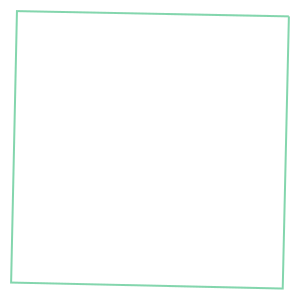

In [82]:
testObj

In [68]:
working_counties.columns

Index(['STATEID', 'PARCELID', 'TAXPARCELID', 'PARCELDATE', 'TAXROLLYEAR',
       'OWNERNME1', 'OWNERNME2', 'PSTLADRESS', 'SITEADRESS', 'ADDNUMPREFIX',
       'ADDNUM', 'ADDNUMSUFFIX', 'PREFIX', 'STREETNAME', 'STREETTYPE',
       'SUFFIX', 'LANDMARKNAME', 'UNITTYPE', 'UNITID', 'PLACENAME', 'ZIPCODE',
       'ZIP4', 'STATE', 'SCHOOLDIST', 'SCHOOLDISTNO', 'CNTASSDVALUE',
       'LNDVALUE', 'IMPVALUE', 'MFLVALUE', 'ESTFMKVALUE', 'NETPRPTA',
       'GRSPRPTA', 'PROPCLASS', 'AUXCLASS', 'ASSDACRES', 'DEEDACRES',
       'GISACRES', 'CONAME', 'LOADDATE', 'PARCELFIPS', 'PARCELSRC',
       'GeneralElementErrors', 'AddressElementErrors', 'TaxrollElementErrors',
       'GeometricElementErrors', 'Shape_Length', 'Shape_Area', 'geometry'],
      dtype='object')

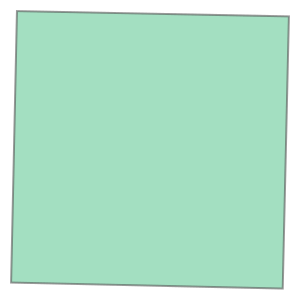

In [83]:
working_counties.loc[0]['geometry']

In [87]:
shapexy_validate = testObj.centroid

In [86]:
shapexy_test = working_counties.loc[0]['geometry'].centroid

In [98]:
shapexy_diff = shapexy_test.difference(shapexy_validate)

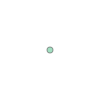

In [103]:
shapexy_diff

In [104]:
shapexy_diff.x, shapexy_diff.y

(407885.3498088562, 449615.5021135079)

In [96]:
shapexy_test.x, shapexy_test.y

(407885.3498088562, 449615.5021135079)

In [100]:
shapexy_validate.x, shapexy_validate.y

(407885.394944749, 449615.5202878421)

In [ ]:
def testCountyEnvelope(self,Parcel):
    specialchars = ['/', '#', '&']  #this special characters occurs in some ParcelIDs
    charsdict = {'&': '%26', '#': '%23', '/': '%2F'}
    parcelid =  str(Parcel.parcelid).upper()
    for i in specialchars:
        while parcelid is not None and i in parcelid:
            parcelid = parcelid[:parcelid.find(i)] + charsdict[i] + parcelid[parcelid.find(i)+1:]
    try:
        #baseURL = "http://mapservices.legis.wisconsin.gov/arcgis/rest/services/WLIP_V3/V3_Parcels/FeatureServer/0/query"
        baseURL = "http://mapservices.legis.wisconsin.gov/arcgis/rest/services/WLIP/Parcels/FeatureServer/0/query"
        where =  str(Parcel.parcelfips) + parcelid
        query = "?f=json&where=STATEID+%3D+%27{0}%27&geometry=true&returnGeometry=true&spatialRel=esriSpatialRelIntersects&outFields=OBJECTID%2CPARCELID%2CTAXPARCELID%2CCONAME%2CPARCELSRC&outSR=3071&resultOffset=0&resultRecordCount=10000".format(where)
        fsURL = baseURL + query
        #arcpy.AddMessage(fsURL)
        fs = arcpy.FeatureSet()
        fs.load(fsURL)
        with arcpy.da.UpdateCursor(fs,["SHAPE@XY"]) as cursorLTSB:
            for rowLTSB in cursorLTSB:
                v2x = round(rowLTSB[0][0],2)
                v1x = round(Parcel.shapeXY[0],2)
                v2y = round(rowLTSB[0][1],2)
                v1y = round(Parcel.shapeXY[1],2)
                diffx = v2x - v1x
                diffy = v2y - v1y
                if (v2x == v1x) and (v2y == v1y):
                    validatedGeomCount += 1
                    if (validatedGeomCount % 10 == 0):
                        # arcpy.AddMessage("  Checking parcel geometry ...\n")
                        pass
                    return "Valid"
                else:
                    diffxy = round(math.sqrt (diffx*diffx + diffy*diffy),2)
                    self.diffxy = self.diffxy + diffxy
                    self.notConfirmGeomCount += 1
                    if (self.notConfirmGeomCount % 10 == 0):
                        # arcpy.AddMessage("  Parcel geometry not validated yet, will attempt another record.")
                        pass
                    return "Not Confirmed"
                    # Call it valid If the query returns no features (failure to return features would not be caused by a misalignment)
        return "Valid"
    except:
        # Call it valid if an error happens (error would not be caused by a misalignment)
        return "Valid"
    return "Valid"

# Fiona

In [4]:
import fiona

In [144]:
counties_f = fiona.open(second_test_counties)

In [134]:
fiona.listlayers(test_counties)

['FOREST', 'TREMPEALEAU', 'FOREST_2', 'TREMPEALEAU_2']

In [25]:
driver = counties_f.driver

In [26]:
driver

'OpenFileGDB'

In [28]:
counties_f.schema

{'properties': OrderedDict([('STATEID', 'str:100'),
              ('PARCELID', 'str:100'),
              ('TAXPARCELID', 'str:100'),
              ('PARCELDATE', 'str:25'),
              ('TAXROLLYEAR', 'str:10'),
              ('OWNERNME1', 'str:254'),
              ('OWNERNME2', 'str:254'),
              ('PSTLADRESS', 'str:200'),
              ('SITEADRESS', 'str:200'),
              ('ADDNUMPREFIX', 'str:50'),
              ('ADDNUM', 'str:50'),
              ('ADDNUMSUFFIX', 'str:50'),
              ('PREFIX', 'str:50'),
              ('STREETNAME', 'str:50'),
              ('STREETTYPE', 'str:50'),
              ('SUFFIX', 'str:50'),
              ('LANDMARKNAME', 'str:50'),
              ('UNITTYPE', 'str:50'),
              ('UNITID', 'str:50'),
              ('PLACENAME', 'str:100'),
              ('ZIPCODE', 'str:50'),
              ('ZIP4', 'str:50'),
              ('STATE', 'str:50'),
              ('SCHOOLDIST', 'str:50'),
              ('SCHOOLDISTNO', 'str:50'),
        

In [29]:
len(counties_f)

21839

# OGR

In [5]:
from osgeo import ogr
import os

In [19]:
datasource = ogr.GetDriverByName('OpenFileGDB').Open(test_counties, 0)

files_list = []
feature_classes = []

for layerIndex in range(datasource.GetLayerCount()):
    layer = datasource.GetLayerByIndex(layerIndex)
    feature_classes.append(os.path.join(test_counties, layer.GetName()))
    files_list.append(layer.GetName())

In [15]:
files_list

['FOREST',
 'TREMPEALEAU',
 'test',
 'testOut',
 'testOut2',
 'testOut3',
 'test4',
 'test1',
 'test2',
 'test3']

In [16]:
feature_classes

['D:\\Data Storage\\Parcel\\Test_counties.gdb\\FOREST',
 'D:\\Data Storage\\Parcel\\Test_counties.gdb\\TREMPEALEAU',
 'D:\\Data Storage\\Parcel\\Test_counties.gdb\\test',
 'D:\\Data Storage\\Parcel\\Test_counties.gdb\\testOut',
 'D:\\Data Storage\\Parcel\\Test_counties.gdb\\testOut2',
 'D:\\Data Storage\\Parcel\\Test_counties.gdb\\testOut3',
 'D:\\Data Storage\\Parcel\\Test_counties.gdb\\test4',
 'D:\\Data Storage\\Parcel\\Test_counties.gdb\\test1',
 'D:\\Data Storage\\Parcel\\Test_counties.gdb\\test2',
 'D:\\Data Storage\\Parcel\\Test_counties.gdb\\test3']